# Tuberculosis(TB) CHEST X-RAY DATABASE Plantilla para filtrar, convertir a format PyTorch y copiar los Datasets


# Cargar los datos del Dataset
## Inicializar librerias

In [1]:
import os
import random

import numpy as np
import pandas as pd

import sklearn.model_selection #Librería para división del dataset

mapa_condiciones = {
    0: "normal",
    1: "tuberculosis",
    2: "neumonia",
    3: "covid-19"
}

## Código de carga del dataset
**Instrucciones:** 
- Cambiar la `direccion_dataset_imagenes` por la ruta correspondiente en sus PCs
- Cargar el dataset en formato pandas.DataFrame y con el siguiente nombre: `direccion_dataset_imagenes`

Nota: En caso de cambiar los nombres de las variables, cambiarlas abajo también.

In [2]:
direccion_dataset_imagenes = "/media/josejacomeb/Datos1/DatasetsMédicos/TB_Chest_Radiography_Database/" #Poner aqui la ruta del dataset donde se encuentren las imagenes
direccion_dataset = "/media/josejacomeb/Datos1/DatasetsMédicos/TB_Chest_Radiography_Database/" #Poner la dirección del dataset aquí
ruta_imagenes_tb= os.path.join(direccion_dataset, "Tuberculosis/")
ruta_imagenes_normales = os.path.join(direccion_dataset, "Normal/")
extension_cxr = "png"
lista_elementos_tb = os.listdir(ruta_imagenes_tb)
lista_elementos_normal = os.listdir(ruta_imagenes_normales)

datos = [] 

condicion_paciente="tuberculosis"
for elemento in lista_elementos_tb:
    ruta_elemento_cxr = os.path.join("Tuberculosis", elemento)
    datos.append({"image_name": ruta_elemento_cxr,  "condition": condicion_paciente})
condicion_paciente="normal"
for elemento in lista_elementos_normal:
    ruta_elemento_cxr = os.path.join("Normal", elemento)
    datos.append({"image_name": ruta_elemento_cxr,  "condition": condicion_paciente})

    dataset_completo = pd.DataFrame(datos) #Guardar el dataset original completo en formato pandas

## Filtrar los datos
**Instrucciones:**
- Usar el DataFrame `dataset_filtrado` para filtrar el dataset por las condiciones dadas y para reducir el numero de datasets en caso de ser necesario
- Usar el DataFrame `dataset_formato_dialung` para convertir el dataset `dataset_filtrado` al Formato DIALUNG que se vio al inicio de la variable


In [44]:
dataset_filtrado = dataset_completo.copy() #Copio el Dataset para no perder los datos, uso copy para hacer un nuevo objeto
########## Operación de filtrar el dataset original ##########
##########
n_imagenes_normal_requeridas = 700 
dataset_filtrado_normal = dataset_filtrado[dataset_filtrado["condition"] == "normal"]
dataset_filtrado_normal = dataset_filtrado_normal.sample(n=n_imagenes_normal_requeridas, replace = False)
n_imagenes_tb_requeridas = 700 
dataset_filtrado_tb = dataset_filtrado[dataset_filtrado["condition"] == "tuberculosis"]
dataset_filtrado_tb = dataset_filtrado_tb.sample(n=n_imagenes_tb_requeridas, replace = False)
dataset_filtrado = pd.concat([dataset_filtrado_tb, dataset_filtrado_normal])
##########
########## Operación de eliminar atributos innecesarios para completar el formato DIALUNG ##########
dataset_formato_dialung = dataset_filtrado.copy() #Copio el dataset filtrado para no perder los atributos originales
##########
dataset_formato_dialung.loc[dataset_filtrado["condition"] == "tuberculosis", 'condition'] = 1
dataset_formato_dialung.loc[dataset_filtrado["condition"] == "normal", 'condition'] = 0
##########
### Impresion de los datos
nombre_segunda_columna = list(dataset_formato_dialung.columns)[1]
print("Tamaño del dataset en formato DIALUNG: {}".format(len(dataset_formato_dialung)))
print("Número de columnas: {} Nombre Columnas: {}".format(len(dataset_formato_dialung.columns), list(dataset_formato_dialung.columns)))
conteo_valores = dataset_formato_dialung[nombre_segunda_columna].value_counts()
for condicion in mapa_condiciones.keys(): #Itero sobre las condiciones
    if condicion in conteo_valores.keys():
        print("Número de muestras por condicion {}: {}".format(mapa_condiciones[condicion], conteo_valores[condicion]))
    

Tamaño del dataset en formato DIALUNG: 1400
Número de columnas: 2 Nombre Columnas: ['image_name', 'condition']
Número de muestras por condicion normal: 700
Número de muestras por condicion tuberculosis: 700


## Dividir el Dataset
En esta función, se divide el dataset que se llama `dataset_formato_dialung` a uno de train(75%), test(15%) y val(10).
Solo ejecutar esta celda sin hacer cambios, más información sobre la División de Datasets en [Training, validation, and test sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets)

In [45]:
#Primero divido el dataset en train 75% y test 25%, no se puede hacer de golpe para los tres datasets
dataset_train, dataset_test = sklearn.model_selection.train_test_split(dataset_formato_dialung, train_size=0.75, test_size=0.25)
#Divido el dataset de test en 60% y val 40%, al final de la selección será
dataset_test, dataset_val = sklearn.model_selection.train_test_split(dataset_formato_dialung, train_size=0.6, test_size=0.4)

## Crear el la clase Dataset de tipo PyTorch Dataset
Crea el dataset en formato Torch.data.Dataset, no hace falta modificar esta clase, solo ejecutarla

In [33]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, io
from torchvision.transforms import Compose


class crearDatasetDIALUNG(Dataset):
    """
    Una clase que hereda los clase torch.utils.data.Dataset para crear un objeto que pueda ser 
    manipulado por la clase DataLoader de PyTorch
    ...

    Atributos
    ----------
    img_labels : pandas.DataFrame
        un objeto de tipo pandas.Dataframe que tiene dos columnas, la primera nombre de la imagen y segunda condicion
    img_dir : str
        Directorio de las imagenes de los datasets
    transform : torchvision.transforms
        Transformaciones de formato PyTorch para aplicar las imagenes
    target_transform : int
        Especifica las transformaciones de la etiqueta y características

    Métodos
    -------
    __len__(self)
        Devuelve el tamaño del dataframe
    """
    def __init__(self, pandas_file, img_dir, transform=None, target_transform=None):
        """
        Parámetros
        ----------
        pandas_file : pandas.DataFrame
            un objeto de tipo pandas.Dataframe que tiene dos columnas, la primera nombre de la imagen y segunda condicion
        img_dir : str
            Directorio de las imagenes de los datasets
        transform : torchvision.transforms
            Transformaciones de formato PyTorch para aplicar las imagenes
        target_transform : int
            Especifica las transformaciones de la etiqueta y características

        """
        self.img_labels = pandas_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """
        Devuelve
        ----------
        int 
            El tamaño del DataFrame en entero
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """Obtiene la imagen del idx del dataset, lee en formato Tensor, aplica las transformaciones
        y devuelve una imagen y su etiqueta.
        Parámetros
        ----------
        idx : int
            índice secuencial de la imagen que se localiza en el DataFrame
        Devuelve
        ----------
        torch.Tensor
            La imagen en formato tensor de PyTorch en Escala de Grises (Tensor[1, alto_imagen, ancho_imagen])
        int 
            La etiqueta correspondiente de la imagen
        """
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) #Busco el nombre de la imagen en la columna cero
        image = read_image(img_path, io.image.ImageReadMode.GRAY) #transformo mi imagen directamente a Escala de grises
        label = self.img_labels.iloc[idx, 1] #Busco el nombre de la etiqueta el DataFrame
        if self.transform: #Aplico transformacion(es) de la imagen
            image = self.transform(image)
        if self.target_transform: #Aplico transformacion(es) a los labels
            label = self.target_transform(label)
        return image, label

## Crear los objetos de tipo crearDatasetDIALUNG que definimos anteriormente
Sino se ha cambiado ninguna variable, solo faltaría añadir transformaciones si se necesitan, además del formato [one-hot-encode](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [34]:
from torchvision.transforms import Resize #Cargar herramienta para hacer Rescalado
from torchvision.transforms import Compose #Compose me sirve para apilar varias transformaciones en una sola
from torchvision.transforms import Lambda #Convertir tensor de salida a one-hot-encoded 
import torch 
#Aqui se puede añadir más transformaciones si se desean
resize_transform = Resize((1024,1024)) #Cambiar el tamaño a 1024x1024
transformaciones_dataset = Compose([resize_transform]) #Apila las transformaciones
transformacion_salida = Lambda(lambda y: torch.zeros(4, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)) #Hago un

#Creo objetos de tipo crearDatasetDIALUNG
train_datasetDIALUNG = crearDatasetDIALUNG(dataset_train, direccion_dataset_imagenes, transformaciones_dataset, transformacion_salida)
test_datasetDIALUNG = crearDatasetDIALUNG(dataset_test, direccion_dataset_imagenes, transformaciones_dataset, transformacion_salida)
val_datasetDIALUNG = crearDatasetDIALUNG(dataset_val, direccion_dataset_imagenes, transformaciones_dataset, transformacion_salida)

## Definir los objetos tipo DataLoader de tamaño de 64 imagenes
Solo carga los objetos anteriores, en un formato que se puede iterar en PyTorch

In [35]:
from torch.utils.data import DataLoader #Clase dataloader para cargar en PyTorch los objetos de tipo Dataset

#Creo objetos de tipo DataLoader en lotes de 64 imagenes y barajeados aleatoriamente
train_dataloader = DataLoader(train_datasetDIALUNG, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_datasetDIALUNG, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_datasetDIALUNG, batch_size=64, shuffle=True)

## Verificacion del Dataset de Val
Se verifica el Dataset de validación porque es el más pequeño y demora menos en cargar

Feature batch shape: torch.Size([64, 1, 1024, 1024])
Labels batch shape: torch.Size([64, 4])


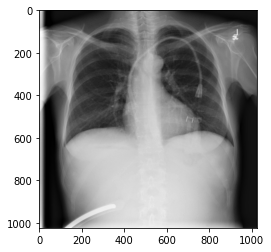

Label one-hot encoding: tensor([1., 0., 0., 0.]) Categoria: normal


In [36]:
import matplotlib.pyplot as plt
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label one-hot encoding: {label} Categoria: {mapa_condiciones[int(torch.argmax(label))]}")

# Guardar los datos finales
## Funciones para copiar el dataset filtrado a una nueva carpeta
Guardar los datasets originales en la ruta deseada y calcula el tamaño del mismo

In [48]:
import math
import shutil #Utilidad para copiar datos

# Funcion para convertir bytes a su represetanción adecuada
#https://stackoverflow.com/questions/5194057/better-way-to-convert-file-sizes-in-python?noredirect=1&lq=1
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "{} {}".format(s, size_name[i])

def anadir_ruta_al_csv(ruta, nombre_dataset):
    return os.path.join(nombre_dataset, ruta)

#Funcion para copiar el dataset a una nueva carpeta
def copiar_dataset_filtrado(dataset, ruta_dataset, carpeta_salida_dataset, nombre_dataset, copiar = False):
    tamano_dataset = 0
    #checo si la carpeta existe
    nuevo_directorio_dataset = os.path.join(carpeta_salida_dataset, nombre_dataset)
    if os.path.exists(nuevo_directorio_dataset):
        print("El Directorio del nuevo dataset {} existe".format(nuevo_directorio_dataset))
    else:
        print("Directorio creado en: {}".format(dataset_formato_dialung))
        os.mkdir(nuevo_directorio_dataset)

    for idx_img in range(len(dataset)):
        ruta_original_imagen = os.path.join(ruta_dataset, dataset_formato_dialung.iloc[idx_img, 0])
        tamano_dataset += os.path.getsize(ruta_original_imagen)
        if copiar:
            shutil.copy(ruta_original_imagen, nuevo_directorio_dataset)

    print("Tamaño del dataset filtrado: {}".format(convert_size(tamano_dataset))) 

def guardar_csv_datasets(carpeta_salida_dataset, nombre_dataset, dataset_original_filtrado, dialung_train, dialung_test, dialung_val):
    nombre_salida_csv = "csv_datasets"
    nuevo_directorio_csv = os.path.join(carpeta_salida_dataset, nombre_salida_csv)
    if os.path.exists(nuevo_directorio_csv):
        print("El Directorio de los csv {} existe".format(nuevo_directorio_csv))
    else:
        print("Directorio  para los csvs creado en: {}".format(nuevo_directorio_csv))
        os.mkdir(nuevo_directorio_csv)
    # Añadir la direccion del nombre del dataset a las rutas de las imagenes
    nombre_primera_columna = list(dataset_formato_dialung.columns)[0]
    dato_columnas = dataset_original_filtrado.loc[:, nombre_primera_columna].apply(lambda x: os.path.join(nombre_dataset,x))
    dataset_original_filtrado.loc[:, nombre_primera_columna]  = dato_columnas
    dato_columnas = dialung_train.loc[:, nombre_primera_columna].apply(lambda x: os.path.join(nombre_dataset,x))
    dialung_train.loc[:, nombre_primera_columna] = dato_columnas
    dato_columnas = dialung_test.loc[:, nombre_primera_columna].apply(lambda x: os.path.join(nombre_dataset,x))
    dialung_test.loc[:, nombre_primera_columna]  = dato_columnas
    dato_columnas = dialung_val.loc[:, nombre_primera_columna].apply(lambda x: os.path.join(nombre_dataset,x))
    dialung_val.loc[:, nombre_primera_columna]  = dato_columnas
    #Guardar los datasets
    dataset_original_filtrado.to_csv(os.path.join(nuevo_directorio_csv, "{}_original_filtrado.csv".format(nombre_dataset)))
    dialung_train.to_csv(os.path.join(nuevo_directorio_csv, "{}_train.csv".format(nombre_dataset)))
    dialung_test.to_csv(os.path.join(nuevo_directorio_csv, "{}_test.csv".format(nombre_dataset)))
    dialung_val.to_csv(os.path.join(nuevo_directorio_csv, "{}_val.csv".format(nombre_dataset)))
    print("Archivos guardados en: {}".format(nuevo_directorio_csv))

## Guardar el dataset filtrado en una nueva carpeta
**Instrucciones:**
- Copiar y pegar una ruta donde se desee copiar el dataset filtrado en la variable`carpeta_salida_dataset_filtrado`
- Por términos de identificación, se recomienda poner el nombre del dataset en la variable `nombre_dataset`
- Si se desea copiar los archivos a la ruta final(Se demora un tiempo y necesita espacio ya asignado), cambiar la línea 4 de `copiar = False` a `copiar = True`

In [49]:
carpeta_salida_dataset_filtrado = "/media/josejacomeb/Datos1/DatasetsMédicos/DatasetFiltrados/" #Carpeta de salida de los datos filtrados
nombre_dataset= "Tuberculosis(TB) CHEST X-RAY DATABASE Filtrado" #Nombre del dataset final para identificación
copiar_dataset_filtrado(dataset_formato_dialung, direccion_dataset_imagenes, 
                        carpeta_salida_dataset_filtrado, nombre_dataset, copiar = False)

El Directorio del nuevo dataset /media/josejacomeb/Datos1/DatasetsMédicos/DatasetFiltrados/Tuberculosis(TB) CHEST X-RAY DATABASE Filtrado existe
Tamaño del dataset filtrado: 208.79 MB


## Guardar los csv de los datasets 
Aquí ya básicamente, si se puso todos los nombres, se ejecuta tranquilamente.

In [50]:
guardar_csv_datasets(carpeta_salida_dataset_filtrado, nombre_dataset, dataset_original_filtrado = dataset_filtrado, 
                     dialung_train = dataset_train, dialung_test = dataset_test, dialung_val = dataset_val )

El Directorio de los csv /media/josejacomeb/Datos1/DatasetsMédicos/DatasetFiltrados/csv_datasets existe
Archivos guardados en: /media/josejacomeb/Datos1/DatasetsMédicos/DatasetFiltrados/csv_datasets


/home/josejacomeb/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
